# Bear Classification: From Data Collection to GUI for Model Inference

In this notebook, we are going to understand the concepts and codes discussed in Lesson 2 of fast.ai book and it's Deep Learning Part-1 2020 course. We will be classifying bear into 3 categories: grizzly, black and teddy bears.

Credit: fast.ai team, Jeremy Howard

Install and import the necessary fast.ai packages.

In [1]:
!pip install -Uqq fastbook

In [2]:
import fastai
from fastbook import *

In [3]:
from fastai.vision.widgets import *

**Downloading sample image of grazzly bears for demonstration.**
> We will be using Duckduckgo for downloading the images which is free to use. Even no account is needed to use it.

In [4]:
urls = search_images_ddg('grizzly', max_images = 100)
urls[0] #Sample image

'http://www.vancouverobserver.com/sites/vancouverobserver.com/files/images/article/body/grouse-grizzly_n3d3306-web.jpg'

In [5]:
len(urls) #No of urls returned

100

In [6]:
#Downloading the sample image
dest = './input/grizzly.jpg'
download_url(urls[0], dest)

Path('input/grizzly.jpg')

Let's display the downloaded image

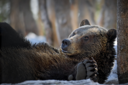

In [7]:
sample_img = PILImage.create(dest)
sample_img.to_thumb(128, 128)

# Download the images of all types of bears required for our model

We will download hundreds of images for each type of bear using Duckduckgo search engine as we did above for just one image of grizzly bear.

In [8]:
bear_types = ('grizzly', 'black', 'teddy') #Creating a tuple of types of bears
path = Path('bears')
path

Path('bears')

In [9]:
type(bear_types)

tuple

In [10]:
for bear_type in bear_types:
    print(bear_type)

grizzly
black
teddy


Downloading images for each type of bear in a separate sub-directories in 'bears' directory

In [11]:
if not path.exists():
    path.mkdir() #Creating parent directory 'bears'
    for bear_type in bear_types:
        dest = (path/bear_type)
        dest.mkdir() #Creating directory for each type of bear
        results = search_images_ddg(f'{bear_type} bear', max_images = 100)
        download_images(dest, urls=results)

Since images should be downloaded in their respective folders, let's verify the folders and images if they are downladed.

In [12]:
path.ls() #Shows the folders available at that path

(#3) [Path('bears/grizzly'),Path('bears/black'),Path('bears/teddy')]

*get_image_files* gets the list of the path of all images in a Path object

In [13]:
fns = get_image_files(path)
fns

(#278) [Path('bears/grizzly/00000047.jpg'),Path('bears/grizzly/00000055.jpg'),Path('bears/grizzly/00000036.jpg'),Path('bears/grizzly/00000030.jpg'),Path('bears/grizzly/00000097.jpg'),Path('bears/grizzly/00000029.jpg'),Path('bears/grizzly/00000091.jpg'),Path('bears/grizzly/00000093.jpg'),Path('bears/grizzly/00000090.jpg'),Path('bears/grizzly/00000002.jpg')...]

Sometimes the images downloaded from internet are corrupt. So, let's check if that is the case.

In [14]:
failed = verify_images(fns)
failed

(#0) []

As we can see above, there are 3 failed/corrupt images hence unlinking them from our dataset.

In [15]:
failed.map(Path.unlink);

# DataLoaders

* We will be using DataBlock API to create DataLoaders as it provides the custom functionalities. Dataloaders loads the data in the required format for the model.
* We need to provide the data type information for independent variable and dependent using <i>blocks</i>. ImageBlock represents that our independent variables are images and CategoryBlock represents that model needs to classify the images into different categories.
* We have to tell how to get a list of input files. For this, we have to pass a function to the **<i>get_items</i>** parameter. As mentioned above, **<i>get_image_files</i>** returns the list of path of all images.
* ***RandomSplitter*** splits the dataset randomly in two sets: Training sets and Validation sets. ***valid_pct=0.2*** tells splitter to use 20% of total data as validation set. ***seed=20*** makes sure that we are getting same set of images in validation set in different epochs so that model can't see these images part of validation set during training.
* ***get_y = parent_label*** tells the Dataloader to get the name of parent folder as label for all images.
* ***item_tfms*** is used to perform the transformations on individual images. ***Resize(128)*** will resize the images into 128x128 pixels.

In [16]:
bears_data_block = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=20),
    get_y = parent_label,
    item_tfms = Resize(128)
)

Loading the data using datalaoder.

In [17]:
dls = bears_data_block.dataloaders(path)

DataLoaders includes Training and Validation Dataloaders. Dataloaders provide the batches of few items at a time to the GPU. 
Let's see some of the images from Training and Testing Dataloaders.

We need to tell how many images we want to get displayed in how many rows. Default value of max_n is 9.

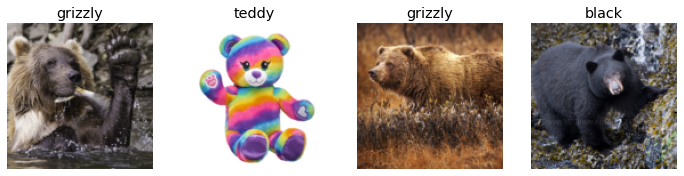

In [18]:
dls.train.show_batch(max_n=4, nrows=1)

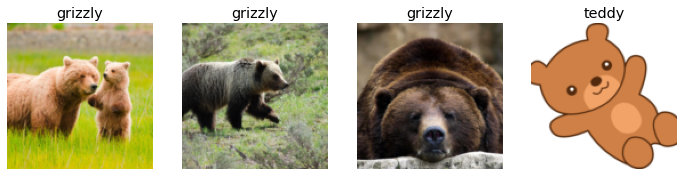

In [19]:
dls.valid.show_batch(max_n=4, nrows=1)

* By default, Resize crops the images in the squared shape of requested size using the full height or weight of the image. We should always keep in mind that cropping the image will cause the loss of some information. Let's try some more types of Resizing method to understand this.
* To apply transformations on existing DataBlock, datablock's new() method is used.
Here, we will squish the images in the 128x128 pixels image.

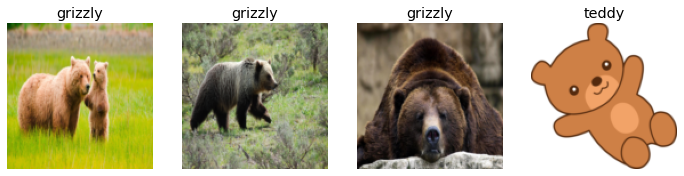

In [20]:
bears_data_block = bears_data_block.new(item_tfms = Resize(128, ResizeMethod.Squish))
dls = bears_data_block.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Here, we will pad the images with zeros (black).

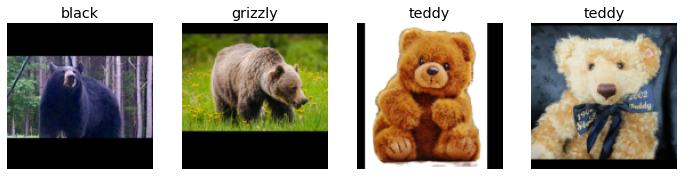

In [21]:
bears_data_block = bears_data_block.new(item_tfms = Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears_data_block.dataloaders(path)
dls.show_batch(max_n = 4, nrows = 1)

As we can see in above images, if we squish or pad the images or resize them in the square shape, it will always lose some information.

Now we are going to randomly crop the images which is very common resizing method. In this method, different parts of images will be cropped in different epoch so that model could learn every important feature. ***min_scale*** determines how much of the image to be cropped each time.

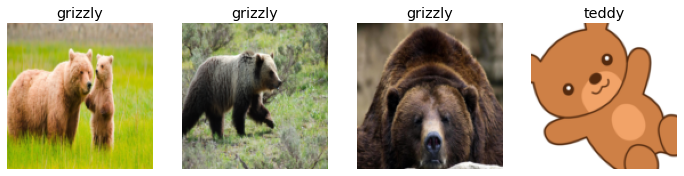

In [22]:
bears_data_block = bears_data_block.new(item_tfms = RandomResizedCrop(128, min_scale=0.3))
dls = bears_data_block.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

To have same image repeated for each version of RandomResizedCrop transform, we need to use *unique=True*.

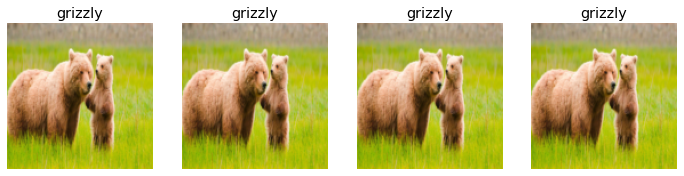

In [23]:
dls.valid.show_batch(max_n=4, nrows=1, unique=True)

# Data Augmentation

* Data augmentation means creating different versions of input data such that they appear different but carry same meaning.
* Some of the common data augmentation techniques are rotation, flipping, warping, brightness changes and contrats changes etc.
* ***aug_transforms*** includes standard set of augmentation techniques. To apply these transformations on batch of data using GPU, we can set this in ***batch_tfms*** parameter in DataBlock.
* The value of ***mult*** decides the extent to which data augmentation is performed.

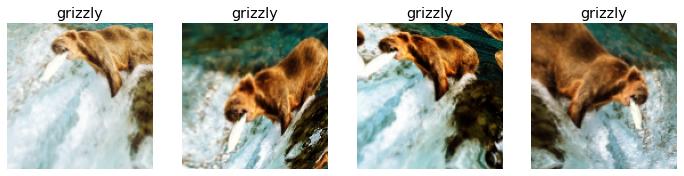

In [24]:
bears_data_block = bears_data_block.new(item_tfms = Resize(128), batch_tfms = aug_transforms(mult=2))
dls = bears_data_block.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

All four images are actually same image after augmentation. We can see the Rotation in first and third images, increased brightness in 4th image.

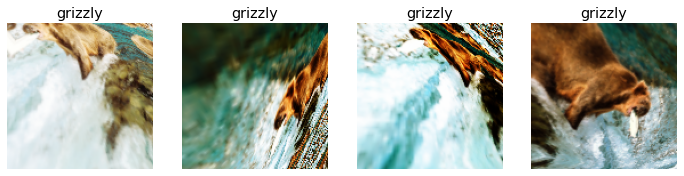

In [25]:
bears_data_block = bears_data_block.new(item_tfms = Resize(128), batch_tfms = aug_transforms(mult=3))
dls = bears_data_block.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In the above images, we can clearly see the effect of change in value of ***mult***.

# Training the Model

Now we will train our model. Here, I am creating a new DataBlock with RandomResizedCrop for individual item transformations and aug_transforms for batch transformations.

In [26]:
bears_data_block = DataBlock(
                        blocks = (ImageBlock, CategoryBlock),
                        get_items = get_image_files,
                        splitter = RandomSplitter(valid_pct=0.2, seed=4),
                        get_y = parent_label,
                        item_tfms = RandomResizedCrop(224, min_scale = 0.3),
                        batch_tfms = aug_transforms(mult=1)
                    )

In [27]:
dls = bears_data_block.dataloaders(path)

In [28]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [29]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.962965,0.339753,0.090909,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.515160,0.083714,0.018182,00:15
1,0.327765,0.050746,0.018182,00:14
2,0.240824,0.057305,0.018182,00:14
3,0.201080,0.043249,0.018182,00:14


We have achieved 100% accuracy in just 4 epochs during training.

# Confusion Matrix

* Confusion matrix is used to see how many inputs are wrongly labeled. Diagonal of the matrix shows the images that are classified correctly. Other cells represent the wrongly classified images. In this case, all images are classified correctly.
**Note: Confusion matrix is calculated using validation set.**

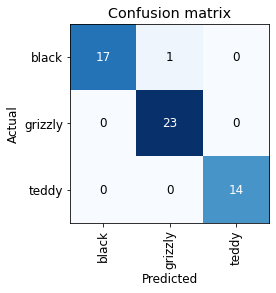

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

***plot_top_losses*** shows us the images with highest loss. It also includes the correctly classified images with low confidence. Images will be labeled with four things: *Prediction, actual value, loss, and probability.*

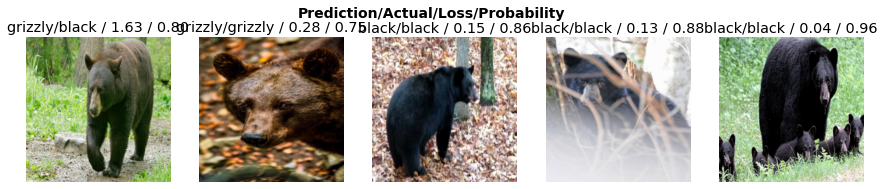

In [31]:
interp.plot_top_losses(5, nrows=1)

# Cleaning Data after Training

Generally, we do data cleaning before the training of the model but fast.ai provides us a way to do data cleaning even after the training of the model. It lets us see the data in training and validation sets and we can decide whether we want to delete or re-label them.

***ImageClassifierCleaner*** do not delete the images. It allows us to select images where images are displayed in the decreasing loss order (highest loss to lowest). It provides a GUI having menues with the option to keep, delete or re-label.

In [32]:
cleaner = ImageClassifierCleaner(learn)
cleaner

To delete the images, we need to select *delete* option for that respective image. *ImageClassifierCleaner* will not delete the images, instead it provides us the indices of those images. We can use those indices to unlink them.

In [33]:
for i in cleaner.delete():
    cleaner.fns[i].unlink()

To move images for which we have selected category, we need to run following code.

In [34]:
for i, category in cleaner.change():
    shutil.move(str(cleaner.fns[i]), path/category)

After the incorrect labelled are either deleted or re-labeled after the training, we can re-train the model. But since our model alreay achieved 100% accuracy on validation set, we are not going to re-train the model.

# Using the model for Inference

* Now since our model are trained, it's inference time. Since the model is trained in this notebook itself, we can directly do the ineference. But I am going to show a way we can do the inference in case of training would have happened in some other notebook.
* First, we need to export the model. We will use the *export()* method. It will export the model in *.pkl* format which we can use further for inference anywhere either in this notebook or another notebook or any kind of app.

In [35]:
learn.export()

Let's confirm if there is any *.pkl* file since we have exported the model.

In [36]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

We can see there is a *.pkl* file which is our exported model.

Before doing the inference/prediction, we need to load the exported the model.

In [37]:
predictor = load_learner(path/'export.pkl')

Since our model is loaded back, we can do the prediction/inference.

In [46]:
predictor.predict('../clean/images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([3.1470e-05, 9.9994e-01, 2.5491e-05]))

* There are 3 things that *predict()* method gives us.
    1. Predicted Value
    2. Index of the predicted category
    3. List of probabilities

* Second value tells which value to look in the list of probabilities. Here value at index 1 is the probability of given bear being a grizzly bear i.e. 0.999998.

This index will be the same as index of predicted category in vocab of dataloader.

In [47]:
predictor.dls.vocab

['black', 'grizzly', 'teddy']

# Creating GUI for the notebook app

In this section, we are going to create a GUI inside the notebook itself. It will be like a mini web app for our model inference. We will use iPython widgets for this purpose. fast.ai provides us these widgets as well.

In [48]:
from fastai.vision.widgets import *

First, we will create the upload button which will let us uplaod the image needed for prediction.

In [49]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [50]:
img = PILImage.create(btn_upload.data[-1])

Creating an output button to display the image.

In [51]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl:
    display(img.to_thumb(128,128))
out_pl

Output()

Getting the prediction of the uploaded image.

In [52]:
pred, pred_idx, prob = predictor.predict(img)

Creating a Label widgets which will show the prediction in the form of a sentence.

In [53]:
label = widgets.Label()
label.value = f'Prediction: {pred}, Probability: {prob[pred_idx]:.04f}'
label

Label(value='Prediction: grizzly, Probability: 1.0000')

Now, we will create a button to classify the images but this button will not do anything unless we define the *on-click* behaviour for this button.

In [54]:
predict_btn = widgets.Button(description='Classify')
predict_btn

Button(description='Classify', style=ButtonStyle())

Since we have shown all the components separately, it's time to pull up all of them together and put them in a vertical box to look like a mini web app. For this, we are going to define all those widgets again.

In [55]:
upload_btn = widgets.FileUpload()
output = widgets.Output()
label_btn = widgets.Label()
predict_btn = widgets.Button(description='Classify')

Defining the on-click behaviour of the *classify button* :

In [56]:
def on_click_classify(change):
    img = PILImage.create(upload_btn.data[-1])
    output.clear_output()
    with output:
        display(img.to_thumb(128,128))
    pred, pred_idx, prob = predictor.predict(img)
    label_btn.value = f'Prediction: {pred}, Probability: {prob[pred_idx]:.04f}'

In [57]:
predict_btn.on_click(on_click_classify)

Finally, create a virtual box *vbox* widget to accomodate all other widgets inside it. Hurray, our app is ready now to do the prediction.

In [58]:
VBox([widgets.Label('Upload the picture of a bear'), upload_btn, predict_btn, output, label_btn])